# Adult Dataset

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity

import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
def load_dataset():
  lab_enc = LabelEncoder()
  ord_enc = OrdinalEncoder()
  column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
  adult_df = pd.read_csv('data/adult.data', names=column_names)
  adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (
      adult_df['race'] != ' White')].index, inplace=True)
  adult_df.loc[adult_df['native-country'] ==
                ' ?', 'native-country'] = 'Not known'
  adult_df['age_class'] = pd.cut(adult_df['age'],
                                  bins=[0, 9, 19, 29, 39, 49, 59, 69, 99],
                                  labels=['age<10', 'age between 10 and 20', 'age between 20 and 30',
                                          'age between 30 and 40', 'age between 40 and 50',
                                          'age between 50 and 60', 'age between 60 and 70', 'age>70']
                                  )
  adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                                            bins=[0, 9, 19, 29, 39, 49, 99],
                                            labels=['hour<10', 'hours between 10 and 20', 'hours between 20 and 30',
                                                    'hours between 30 and 40', 'hour between 40 and 50',
                                                    'hour>70']
                                            )
  adult_df.drop(labels=['hours-per-week', 'workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'age', 'education-num'],
                axis=1, inplace=True)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['education'])).drop('education', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['marital-status'])).drop('marital-status', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['occupation'])).drop('occupation', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['relationship'])).drop('relationship', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['native-country'])).drop('native-country', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['age_class'])).drop('age_class', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['hour-per-week-class'])).drop('hour-per-week-class', axis=1)
  adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
  adult_df[['sex', 'race']] = ord_enc.fit_transform(
      adult_df[['sex', 'race']])
  return adult_df


In [3]:
data = load_dataset()

In [4]:
label = 'income'
sensitive_features = ['race', 'sex']
unpriv_group = {'sex': 0, 'race': 0}
positive_label = 1

In [5]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)

## Biased data

In [6]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Statistical parity:  -0.17  +-  0.016
Disparate impact:  0.174  +-  0.067
Zero one loss:  0.156  +-  0.01
F1 score:  0.829  +-  0.007
Accuracy score:  0.835  +-  0.007


## Exponentiated gradient

### Demographic parity

In [8]:
exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=DemographicParity(),
    sample_weight_name="classifier__sample_weight")

model, exp_metrics = cross_val(exponentiated_gradient, data, label, unpriv_group, sensitive_features, exp=True, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/anaconda3/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/anaconda3/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future ve

Training time: ~ 3 min 50 secs

In [9]:
print_metrics(exp_metrics)

Statistical parity:  -0.01  +-  0.028
Disparate impact:  0.855  +-  0.112
Zero one loss:  0.116  +-  0.013
F1 score:  0.807  +-  0.004
Accuracy score:  0.82  +-  0.005


### Zero One Loss

In [10]:
constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)

In [11]:
exponentiated_gradient = ExponentiatedGradient(
    estimator=pipeline,
    constraints=constr,
    sample_weight_name="classifier__sample_weight")

model, zerol_metrics = cross_val(
    exponentiated_gradient, data.copy(), label, unpriv_group, sensitive_features, exp=True, positive_label=positive_label)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Training time: ~ 2 min 18 s

In [12]:
print_metrics(zerol_metrics)

Statistical parity:  -0.179  +-  0.01
Disparate impact:  0.11  +-  0.039
Zero one loss:  0.159  +-  0.01
F1 score:  0.826  +-  0.009
Accuracy score:  0.833  +-  0.008


## DEMV

In [14]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [14]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

Training time: ~27 min

In [15]:
iters = demv.get_iters()

In [16]:
print_metrics(demv_metrics)

Statistical parity:  -0.098  +-  0.02
Disparate impact:  0.482  +-  0.108
Zero one loss:  0.142  +-  0.015
F1 score:  0.824  +-  0.004
Accuracy score:  0.832  +-  0.004


## DEMV evaluation

In [17]:
metrics = eval_demv(200, 1081, data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

Training time: 205 mins

In [18]:
df = prepareplots(metrics,'adult')

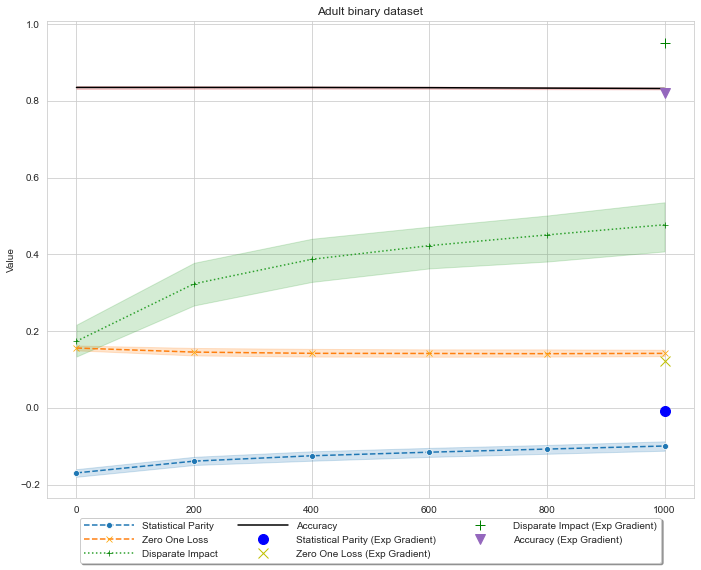

In [41]:
#iters = 1000
points = preparepoints(exp_metrics, demv.get_iters())

plot_metrics_curves(df, points, 'Adult binary dataset')

In [16]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 30940
Unprivileged group size: 1555
Percentage of unprivileged group: 5.025856496444732
Number of iterations: 0
